In [ ]:
import os
import pathlib
import shutil
import cv2
import gc
import keras
import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (BatchNormalization, Dense, Dropout, Flatten)
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import random
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!kaggle datasets download -d nodoubttome/skin-cancer9-classesisic

100% 784M/786M [00:07<00:00, 55.9MB/s]
100% 786M/786M [00:07<00:00, 111MB/s] 


In [ ]:
from zipfile import ZipFile
file_name = "/content/skin-cancer9-classesisic.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
!pip install split-folders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

splitfolders.ratio("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train", # The location of dataset
                   output="{output_directory}", # The output location
                   seed=42, # The number of seed
                   ratio=(.7,.2,.1), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

Copying files: 2239 files [00:01, 1167.75 files/s]


In [ ]:
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test")
data_dir_val = pathlib.Path("/content/{output_directory}/val")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)
image_count_val = len(list(data_dir_val.glob('*/*.jpg')))
print(image_count_val)

2239
118
444


In [ ]:
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
for label in class_names:
    print(label + " train: " + str(len(os.listdir(os.path.join(data_dir_train, label)))))
print("\n")

for label in class_names:
    print(label + " val: " + str(len(os.listdir(os.path.join(data_dir_val, label)))))
print("\n")

for label in class_names:
    print(label + " test: " + str(len(os.listdir(os.path.join(data_dir_test, label)))))

actinic keratosis train: 114
basal cell carcinoma train: 376
dermatofibroma train: 95
melanoma train: 438
nevus train: 357
pigmented benign keratosis train: 462
seborrheic keratosis train: 77
squamous cell carcinoma train: 181
vascular lesion train: 139


actinic keratosis val: 22
basal cell carcinoma val: 75
dermatofibroma val: 19
melanoma val: 87
nevus val: 71
pigmented benign keratosis val: 92
seborrheic keratosis val: 15
squamous cell carcinoma val: 36
vascular lesion val: 27


actinic keratosis test: 16
basal cell carcinoma test: 16
dermatofibroma test: 16
melanoma test: 16
nevus test: 16
pigmented benign keratosis test: 16
seborrheic keratosis test: 3
squamous cell carcinoma test: 16
vascular lesion test: 3


In [ ]:
data_gen_param = {
    "rotation_range": 180,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "zoom_range": 0.1,
    "horizontal_flip": True,
    "vertical_flip": True
}
data_generator = ImageDataGenerator(**data_gen_param)
num_images_each_label = 6000
base_dir =pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration")
aug_dir2 = os.path.join( base_dir, "aug_dir2")
os.mkdir(aug_dir2)
for label in class_names:
    
    img_dir = os.path.join(aug_dir2, "aug_img")
    os.mkdir(img_dir)
    
    src_dir_label = os.path.join(data_dir_train, label)
    for image_name in os.listdir(src_dir_label):
        shutil.copy(os.path.join(src_dir_label, image_name), os.path.join(img_dir, image_name))
    
    batch_size = 32
    data_flow_param = {
  "directory": aug_dir2,
"color_mode": "rgb",
        "batch_size": batch_size,
        "shuffle": True,
        "save_to_dir": os.path.join(data_dir_train, label),
        "save_format": "jpg"
    }
    aug_data_gen = data_generator.flow_from_directory(**data_flow_param)
    num_img_aug = num_images_each_label - len(os.listdir(os.path.join(data_dir_train, label)))
    num_batch = int(num_img_aug / batch_size)
    
    for i in range(0, num_batch):
        next(aug_data_gen)
    
    shutil.rmtree(img_dir)


Found 114 images belonging to 1 classes.
Found 376 images belonging to 1 classes.
Found 95 images belonging to 1 classes.
Found 438 images belonging to 1 classes.
Found 357 images belonging to 1 classes.
Found 462 images belonging to 1 classes.
Found 77 images belonging to 1 classes.
Found 181 images belonging to 1 classes.
Found 139 images belonging to 1 classes.


In [ ]:
IMAGE_SHAPE = (224, 224, 3)
data_gen_param = {
    "samplewise_center": True,
    "samplewise_std_normalization": True,
    "rotation_range": 180,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "zoom_range": 0.1,
    "horizontal_flip": True,
    "vertical_flip": True,
    "rescale": 1.0 / 255
    

}
data_generator = ImageDataGenerator(**data_gen_param)
train_flow_param = {
    "directory": data_dir_train,
    "batch_size": 64,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": True,
    
}
train_flow = data_generator.flow_from_directory(**train_flow_param)



val_flow_param = {
    "directory": data_dir_val,
    "batch_size": 1,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": False
}
val_flow = data_generator.flow_from_directory(**val_flow_param)

test_flow_param = {
    "directory": data_dir_test,
    "batch_size": 1,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": False
}
test_flow = data_generator.flow_from_directory(**test_flow_param)


Found 50111 images belonging to 9 classes.
Found 444 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [ ]:
dropout_dense = 0.1
mobilenet_model = MobileNet(input_shape=IMAGE_SHAPE, include_top=False, pooling="max")

model = Sequential()
model.add(mobilenet_model)
model.add(Dropout(dropout_dense))
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(64, activation="relu"))
model.add(Dropout(dropout_dense))
model.add(BatchNormalization())
model.add(Dense(9, activation="softmax"))

def top_2_acc(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3_acc(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

model.compile(Adam(0.001), loss="categorical_crossentropy", metrics=[categorical_accuracy, top_2_acc, top_3_acc])

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
filepath = "model.h5"

checkpoint_param = {
    "filepath": filepath,
    "monitor": "val_categorical_accuracy",
    "verbose": 1,
    "save_best_only": True,
    "mode": "max"
}
checkpoint = ModelCheckpoint(**checkpoint_param)

lr_decay_params = {
    "monitor": "val_loss",
    "factor": 0.5,
    "patience": 2,
    "min_lr": 1e-5
}
lr_decay = ReduceLROnPlateau(**lr_decay_params)
early_stopping = EarlyStopping(monitor="val_loss", patience=4, verbose=1)

In [ ]:
mobilenet_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [ ]:

print("Training the model...")

history = model.fit(train_flow,steps_per_epoch=32,epochs=50,verbose=1,validation_data=val_flow,validation_steps=32,callbacks = [checkpoint, lr_decay])
print("Done!")

Training the model...
Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 2.1496 - categorical_accuracy: 0.2769 - top_2_acc: 0.4409 - top_3_acc: 0.5771
Epoch 1: val_categorical_accuracy improved from -inf to 0.00000, saving model to model.h5
32/32 [==============================] - 46s 955ms/step - loss: 2.1496 - categorical_accuracy: 0.2769 - top_2_acc: 0.4409 - top_3_acc: 0.5771 - val_loss: 10.0207 - val_categorical_accuracy: 0.0000e+00 - val_top_2_acc: 0.0000e+00 - val_top_3_acc: 0.0000e+00 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 1.4835 - categorical_accuracy: 0.4487 - top_2_acc: 0.6802 - top_3_acc: 0.8008
Epoch 2: val_categorical_accuracy did not improve from 0.00000
32/32 [==============================] - 33s 1s/step - loss: 1.4835 - categorical_accuracy: 0.4487 - top_2_acc: 0.6802 - top_3_acc: 0.8008 - val_loss: 6.3447 - val_categorical_accuracy: 0.0000e+00 - val_top_2_acc: 0.0000e+00 - val_top_3_acc: 0.0000e+00 - lr: 0.00

In [ ]:
_, val_acc, val_top_2_acc, val_top_3_acc = model.evaluate(val_flow, steps=len(val_flow))
y_val_true = val_flow.classes
y_val_pred = np.argmax(model.predict(val_flow, steps=len(val_flow)), axis=1)
val_f1_score = f1_score(y_val_true, y_val_pred, average="micro")

print("Validation accuracy: {:.4f}".format(val_acc))
print("Validation top-2 accuracy: {:.4f}".format(val_top_2_acc))
print("Validation top-3 accuracy: {:.4f}".format(val_top_3_acc))
print("Validation F1 score: {:.4f}".format(val_f1_score))

444/444 [==============================] - 14s 31ms/step
Validation accuracy: 0.8356
Validation top-2 accuracy: 0.9505
Validation top-3 accuracy: 0.9910
Validation F1 score: 0.8131


In [ ]:
_, test_acc, test_top_2_acc, test_top_3_acc = model.evaluate(test_flow, steps=len(test_flow))
y_test_true = test_flow.classes
y_test_pred = np.argmax(model.predict(test_flow, steps=len(test_flow)), axis=1)
test_f1_score = f1_score(y_test_true, y_test_pred, average="micro")

print("Test accuracy: {:.4f}".format(test_acc))
print("Test top-2 accuracy: {:.4f}".format(test_top_2_acc))
print("Test top-3 accuracy: {:.4f}".format(test_top_3_acc))
print("Test F1 score: {:.4f}".format(test_f1_score))

118/118 [==============================] - 11s 97ms/step
Test accuracy: 0.5763
Test top-2 accuracy: 0.8136
Test top-3 accuracy: 0.8814
Test F1 score: 0.5678


In [ ]:
loss_train = history.history["loss"]
acc_train = history.history["categorical_accuracy"]
loss_val = history.history["val_loss"]
acc_val = history.history["val_categorical_accuracy"]
epochs = np.arange(1, len(loss_train) + 1)

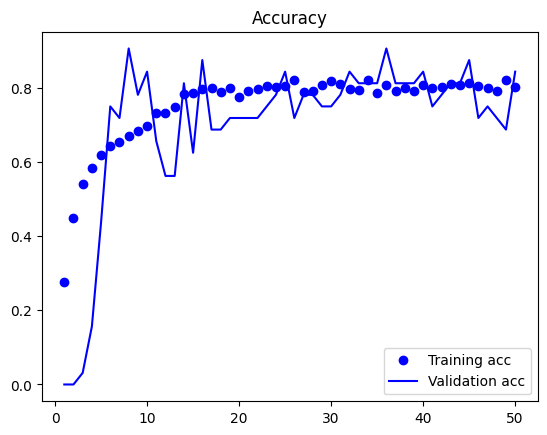

In [ ]:
plt.plot(epochs, acc_train, "bo", label="Training acc")
plt.plot(epochs, acc_val, "b", label="Validation acc")
plt.title("Accuracy")
plt.legend()
plt.show()

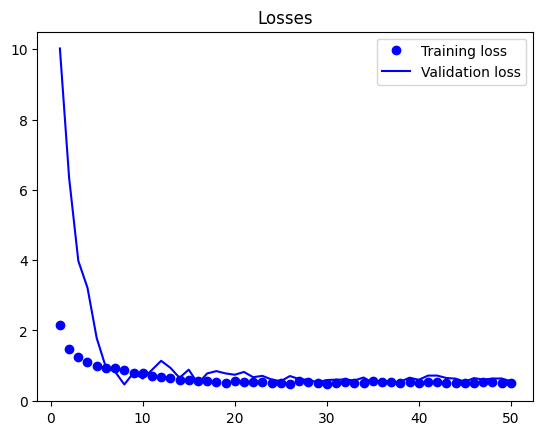

In [ ]:
plt.plot(epochs, loss_train, "bo", label="Training loss")
plt.plot(epochs, loss_val, "b", label="Validation loss")
plt.title("Losses")
plt.legend()
plt.show()

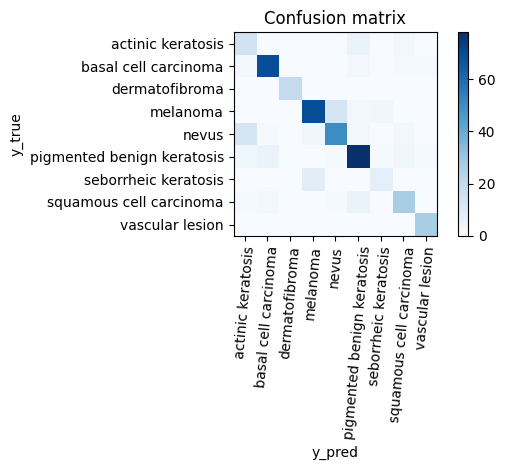

In [ ]:
conf_mat = confusion_matrix(y_val_true, y_val_pred)
plt.imshow(conf_mat, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=85)
plt.yticks(tick_marks, class_names)
plt.ylabel("y_true")
plt.xlabel("y_pred")
plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Make predictions on the test set
y_pred = model.predict(test_flow)
# Convert predictions to class labels
y_pred = np.argmax(y_pred, axis=1)
# Convert true labels to class labels
y_true = test_flow.classes
# Calculate precision, recall, and f1 score
report = classification_report(y_true, y_pred, target_names = class_names)
print(report)


118/118 [==============================] - 15s 128ms/step
                            precision    recall  f1-score   support

         actinic keratosis       0.86      0.38      0.52        16
      basal cell carcinoma       0.60      0.75      0.67        16
            dermatofibroma       1.00      0.50      0.67        16
                  melanoma       0.14      0.06      0.09        16
                     nevus       0.47      0.94      0.62        16
pigmented benign keratosis       0.41      0.69      0.51        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.46      0.38      0.41        16
           vascular lesion       0.75      1.00      0.86         3

                  accuracy                           0.53       118
                 macro avg       0.52      0.52      0.48       118
              weighted avg       0.55      0.53      0.50       118



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Make predictions on the val set
y_pred = model.predict(val_flow)
# Convert predictions to class labels
y_pred = np.argmax(y_pred, axis=1)
# Convert true labels to class labels
y_true = val_flow.classes
# Calculate precision, recall, and f1 score
report = classification_report(y_true, y_pred, target_names = class_names)
print(report)


444/444 [==============================] - 13s 30ms/step
                            precision    recall  f1-score   support

         actinic keratosis       0.46      0.77      0.58        22
      basal cell carcinoma       0.88      0.88      0.88        75
            dermatofibroma       1.00      1.00      1.00        19
                  melanoma       0.88      0.78      0.83        87
                     nevus       0.78      0.70      0.74        71
pigmented benign keratosis       0.86      0.88      0.87        92
      seborrheic keratosis       0.70      0.47      0.56        15
   squamous cell carcinoma       0.65      0.72      0.68        36
           vascular lesion       0.96      1.00      0.98        27

                  accuracy                           0.81       444
                 macro avg       0.80      0.80      0.79       444
              weighted avg       0.83      0.81      0.82       444



In [ ]:
model.save("model.h5")